In [1]:
import numpy as np
import gym
from gym import spaces

class OdorTaskEnv(gym.Env):
    def __init__(self, ntrials, nstates=6, nactions=2, seed=0):
        np.random.seed(seed)
        self.observation_space = spaces.Discrete(nstates) # odors
        self.action_space = spaces.Discrete(nactions) # go/no go
        self.ntrials = ntrials
        self.rewarded_odors = set(np.random.choice(range(nstates), size=nstates//2, replace=False))

    def _get_obs(self):
        return self.current_state

    def _get_info(self):
        return {'trial_number': self.t}

    def _get_reward(self, action):
        if self.current_state in self.rewarded_odors and action == 0:
            return 1.0
        elif self.current_state not in self.rewarded_odors and action == 1:
            return 1.0
        else:
        #    return -1.0
          return -1.0

    def _update_state(self, action=None):
        if action is None:
            self.current_state = self.observation_space.sample()
        else:
            self.current_state = self.observation_space.sample()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._update_state()
        self.t = 0
        return self._get_obs(), self._get_info()

    def step(self, action):
        r = self._get_reward(action)
        self._update_state(action)
        self.t += 1
        terminated = False
        truncated = (self.t >= self.ntrials)
        return self._get_obs(), r, terminated, truncated, self._get_info()


In [2]:
#%%
import numpy as np
import gym
from gym import spaces
class OdorTaskEnv(gym.Env):
    def __init__(self, ntrials, nstates=6, nactions=2, seed=0):
        self.observation_space = spaces.Discrete(nstates) # odors
        self.action_space = spaces.Discrete(nactions) # go/no go
        self.ntrials = ntrials
        # Assuming the first half of states are rewarded in the first phase,
        # and the last half of states are rewarded in the second phase.
        np.random.seed(seed)
        self.rewarded_odors = set(np.random.choice(range(nstates), size=nstates//2, replace=False))
        self.current_state = None
        self.t = 0
    def _get_obs(self):
        return self.current_state

    def _get_info(self):
        return {'trial_number': self.t}

    def _get_reward(self, action):
        if self.current_state in self.rewarded_odors and action == 0:
            return 1.0
        elif self.current_state not in self.rewarded_odors and action == 1:
            return 1.0
        else:
            return -1.0

    def _update_state(self, action=None):
        if self.t <= self.ntrials / 2:
            # Sample from the first half of states
            self.current_state = np.random.choice(list(range(4)))
        else:
            # Sample from the last two and the first two states
            self.current_state = np.random.choice(list(range(2)) + list(range(4, 6)))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._update_state()
        self.t = 0
        return self._get_obs(), self._get_info()

    def step(self, action):
        r = self._get_reward(action)
        self._update_state(action)
        self.t += 1
        terminated = False
        truncated = (self.t >= self.ntrials)
        return self._get_obs(), r, terminated, truncated, self._get_info()



In [3]:
class DiscreteAgent:
    def __init__(self, nstates, nactions, seed=None):
        self.nstates = nstates
        self.nactions = nactions
        self.np_random = np.random.default_rng(seed=seed)

    def update(self, s, a, r, snext, alpha=0):
        pass

    def sample_action(self, s, epsilon=0):
        return self.np_random.choice(self.nactions)

    def get_info(self):
        return {}
class QLearningAgent(DiscreteAgent):
    def __init__(self, nstates, nactions, gamma=0.65):
        super().__init__(nstates, nactions)
        self.gamma = gamma
        self.q_table = np.zeros((nstates, nactions))

    def update(self, s, a, r, snext, alpha=0.1):
        q_update = r + self.gamma * np.max(self.q_table[snext]) - self.q_table[s, a]
        self.q_table[s, a] += alpha * q_update
        rpe = q_update  # RPE is the same as the Q-value update
        return rpe

    def sample_action(self, s, epsilon=0.1):
        if self.np_random.random() < epsilon:
            return self.np_random.choice(self.nactions)
        else:
            return np.argmax(self.q_table[s])

    def get_info(self):
        return {'q_table': self.q_table}

In [4]:
class ParameterizedQLearningAgent(DiscreteAgent):
    '''
    Presets:
    OnlyWPlastic: only w matrix (alpha q = 0) can change, and no freezing of Q matrix after new cues are introduced.
    OnlyQPlastic: only q matrix (W matrix is identity matrix, alpha w = 0) can change, and no freezing of Q matrix after new cues are introduced.
    QWPlastic: both w and q matrices can change, and no freezing of Q matrix after new cues are introduced.
    OnlyWPlasticFreeze: only w matrix (alpha q = 0) can change, and we freeze Q matrix after new cues are introduced.
    OnlyQPlasticFreeze: only q matrix (alpha w = 0) can change, and we freeze Q matrix after new cues are introduced.
    QWPlasticFreeze: both alpha w and alpha q can change, and we freeze Q matrix after new cues are introduced.
    '''

    def __init__(self, nstates, nactions, latent=6, alphaQ=0.005, alphaW=0.015, gamma=0, seed=0, trials=500, preset="QWPlastic"):
        super().__init__(nstates, nactions, seed=seed)
        self.alphaQ = alphaQ
        self.alphaW = alphaW
        self.gamma = gamma
        self.latent = latent
        self.ntrials = trials
        self.preset = preset
        self.t = 0

        np.random.seed(seed)
        self.W = self.initialize_w_matrix(nstates)
        self.Q = self.initialize_q_matrix(nstates, nactions)

    def initialize_w_matrix(self, nstates):
        identity_like_matrix = np.zeros((nstates, self.latent))
        min_dimension = min(nstates, self.latent)

        if self.preset in ["OnlyQPlastic", "OnlyQPlasticFreeze"]:
            for i in range(min_dimension):
                identity_like_matrix[i, i] = 1
            return identity_like_matrix
        else:
            return np.random.randn(nstates, self.latent)

    def initialize_q_matrix(self, nstates, nactions):
        if self.preset in ["OnlyWPlastic", "OnlyWPlasticFreeze"]:
            return np.random.randn(self.latent, nactions)
        else:
            return np.zeros((self.latent, nactions))

    def configure_presets(self):
        preset_configurations = {
            "OnlyWPlastic": {"alphaQ": 0},
            "OnlyQPlastic": {"alphaW": 0},
            "OnlyWPlasticFreeze": {"alphaQ": 0},
            "OnlyQPlasticFreeze": {"alphaW": 0},
            "QWPlastic": {},
            "QWPlasticFreeze": {}
        }

        config = preset_configurations.get(self.preset, {})
        self.alphaQ = config.get("alphaQ", self.alphaQ)
        self.alphaW = config.get("alphaW", self.alphaW)

    def forward_pass(self, one_hot_state):
        self.z = np.dot(one_hot_state, self.W)
        q_values = np.dot(self.z, self.Q)
        return q_values

    def update(self, s, a, r, snext, done):
        self.t += 1
        if self.preset.endswith("Freeze") and self.t >= (self.ntrials / 2):
            self.alphaQ = 0
        one_hot_s = np.zeros(self.nstates)
        one_hot_s[s] = 1
        one_hot_s = one_hot_s.reshape((1, self.nstates))

        one_hot_snext = np.zeros(self.nstates)
        one_hot_snext[snext] = 1
        one_hot_snext = one_hot_snext.reshape((1, self.nstates))

        q_values_current = self.forward_pass(one_hot_s)
        q_values_next = self.forward_pass(one_hot_snext)

        # Compute target Q-value
        target = r + self.gamma * np.max(q_values_next)
        rpe = target - q_values_current[0][a]
        # Compute loss (MSE)
        #loss = (1/2) * (rpe) ** 2

        #  gradient for Q w.r.t loss
        z = np.dot(one_hot_s, self.W)
        grad_Q = (rpe) * z

        #  gradient for W w.r.t loss
        #grad_W = (target - q_values_current[a]) * one_hot_s[:, None] * self.Q[:, a][None, :]
        grad_W = (rpe) * np.outer(one_hot_s, self.Q[:, a])
        # Update Q and W matrices using gradient descent
        action_col = self.Q[:, a]
        Qamount = self.alphaQ * grad_Q[0]
        self.Q[:, a] += Qamount
        Q = self.Q
        WAmount = self.alphaW * grad_W
        self.W += WAmount
        return rpe

    def sample_action(self, s, epsilon=0.1):
        one_hot_s = np.zeros(self.nstates)
        one_hot_s[s] = 1
        one_hot_s = one_hot_s.reshape((1, self.nstates))
        q_values = self.forward_pass(one_hot_s)

        # Epsilon-greedy policy
        if self.np_random.random() < epsilon:
            return self.np_random.choice(self.nactions)
        else:
            return np.argmax(q_values)

    def get_info(self):
        return {'W': self.W, 'Q': self.Q.copy()}


In [5]:
def example(nepisodes=1, latent=6, seed=1, preset="QWPlastic"):
    env = OdorTaskEnv(ntrials=500, seed=seed)
    agent = ParameterizedQLearningAgent(nstates=env.observation_space.n, nactions=env.action_space.n, latent=latent, seed=seed, preset=preset)
    alpha = 0.1
    epsilon = 0.001

    data = []
    for i in range(nepisodes):
        obs, info = env.reset(seed=seed)
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.sample_action(obs, epsilon=epsilon)
            next_obs, r, terminated, truncated, info = env.step(action)
            rpe = agent.update(obs, action, r, next_obs, alpha)
            data.append({
                'episode_index': i,
                'obs': obs,
                'next_obs': next_obs,
                'action': action,
                'r': r,
                'rpe': rpe,
                'info': info,
                'agent_info': agent.get_info()})
            obs = next_obs
    return data, env.rewarded_odors


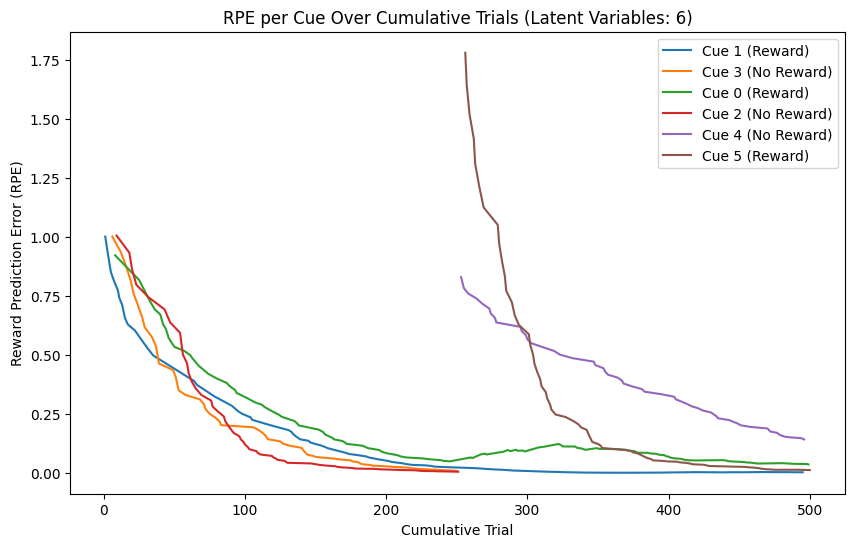

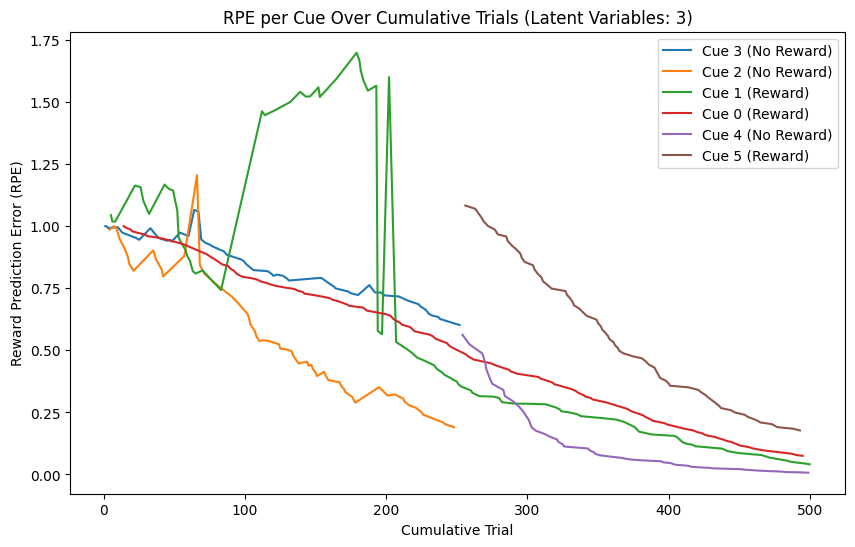

In [6]:
import matplotlib.pyplot as plt

def plot_rpe_per_cue(data, ntrials_per_episode, reward_cues):
    latent = len(data[0]['agent_info']['Q'])

    cue_rpe_data = {}
    for entry in data:
        cue = entry['obs']
        episode_index = entry['episode_index']
        trial = entry['info']['trial_number'] + episode_index * ntrials_per_episode
        rpe = entry['rpe']**2

        if cue not in cue_rpe_data:
            cue_rpe_data[cue] = []
        cue_rpe_data[cue].append((trial, rpe))

    plt.figure(figsize=(10, 6))
    for cue, rpe_values in cue_rpe_data.items():
        trials, rpes = zip(*sorted(rpe_values))
        label = f'Cue {cue} (Reward)' if cue in reward_cues else f'Cue {cue} (No Reward)'
        plt.plot(trials, rpes, label=label)

    plt.xlabel('Cumulative Trial')
    plt.ylabel('Reward Prediction Error (RPE)')
    plt.title(f'RPE per Cue Over Cumulative Trials (Latent Variables: {latent})')
    plt.legend()
    plt.show()

# 42, 12

seed = 42
high_d, high_r = example(latent=6, seed=seed)
low_d, low_r = example(latent=3, seed=seed)
plot_rpe_per_cue(high_d, 500, high_r)
plot_rpe_per_cue(low_d, 500, low_r)

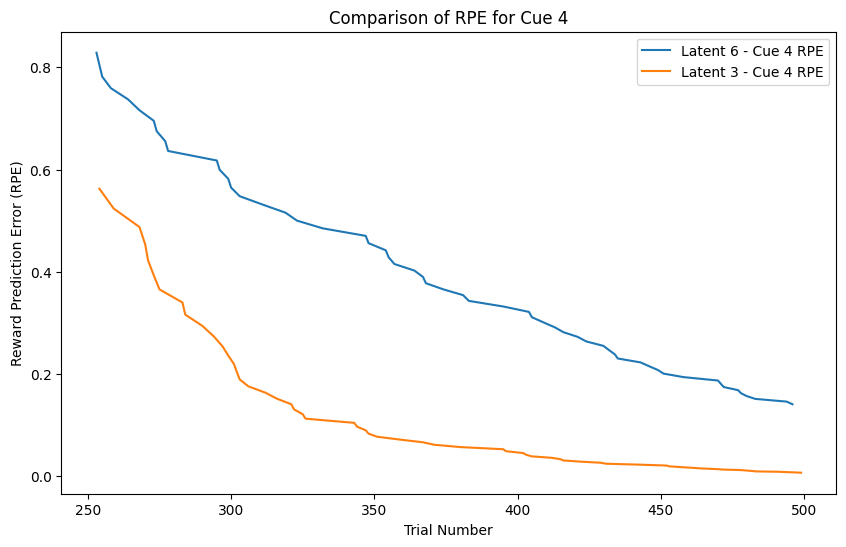

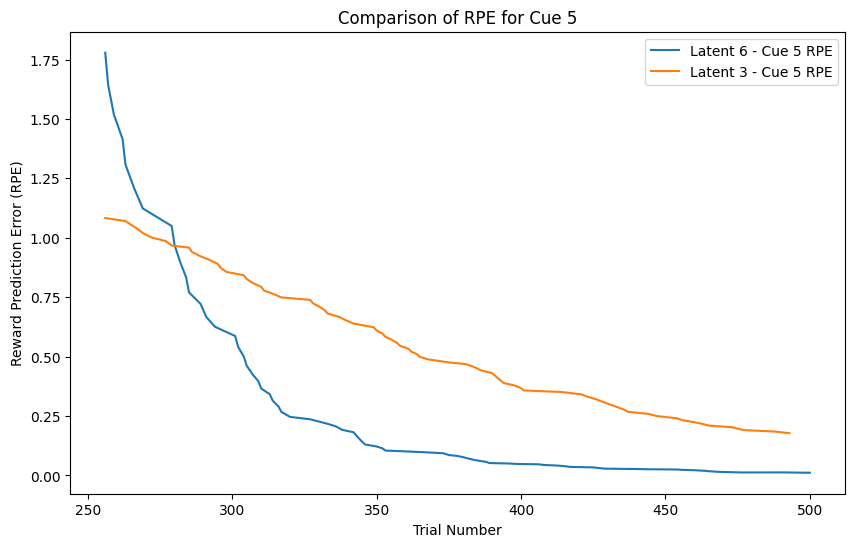

In [7]:
def plot_single_cue_rpe_comparison(high_data, low_data, cue, ntrials_per_episode):
    high_rpe_data = [entry['rpe']**2 for entry in high_data if entry['obs'] == cue]
    low_rpe_data = [entry['rpe']**2 for entry in low_data if entry['obs'] == cue]

    # trials -- from episode index and trial number within each episode
    high_trial_numbers = [entry['info']['trial_number'] + entry['episode_index'] * ntrials_per_episode
                          for entry in high_data if entry['obs'] == cue]
    low_trial_numbers = [entry['info']['trial_number'] + entry['episode_index'] * ntrials_per_episode
                         for entry in low_data if entry['obs'] == cue]

    plt.figure(figsize=(10, 6))

    #  RPE -- higher latent space
    plt.plot(high_trial_numbers, high_rpe_data, label=f'Latent 6 - Cue {cue} RPE')

    #  RPE -- the lowr latent space
    plt.plot(low_trial_numbers, low_rpe_data, label=f'Latent 3 - Cue {cue} RPE')

    plt.xlabel('Trial Number')
    plt.ylabel('Reward Prediction Error (RPE)')
    plt.title(f'Comparison of RPE for Cue {cue}')
    plt.legend()
    plt.show()

plot_single_cue_rpe_comparison(high_d, low_d, cue=4, ntrials_per_episode=500)
plot_single_cue_rpe_comparison(high_d, low_d, cue=5, ntrials_per_episode=500)

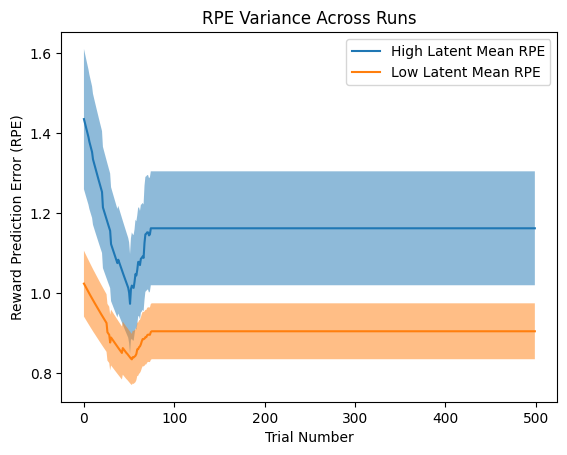

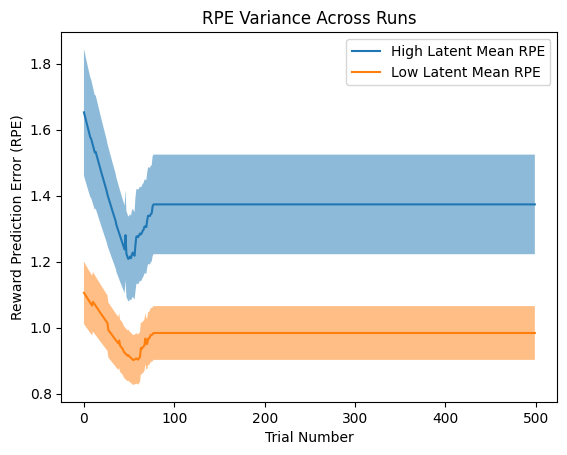

In [19]:
def collect_rpe_data(nruns, latent, cue, ntrials_per_episode, preset):
    rpe_data_all_runs = []

    for run in range(nruns):
        seed = run
        data, _ = example(latent=latent, seed=seed, preset=preset)
        # RPE --specified cue
        rpe_data = [entry['rpe']**2 for entry in data if entry['obs'] == cue]

        # Pad -- mean value if there are not enough RPEs
        if len(rpe_data) < ntrials_per_episode:
            rpe_data += [np.mean(rpe_data)] * (ntrials_per_episode - len(rpe_data))
        # or I thin if there are too many, truncate the list
        rpe_data = rpe_data[:ntrials_per_episode]

        rpe_data_all_runs.append(rpe_data)

    rpe_data_all_runs_array = np.array(rpe_data_all_runs, dtype=float)
    return rpe_data_all_runs_array


def plot_rpe_variance(rpe_data_high, rpe_data_low, ntrials_per_episode, n_trials_to_plot=500):
    mean_high = np.mean(rpe_data_high, axis=0)
    std_high = np.std(rpe_data_high, axis=0)
    std_high /= np.sqrt(len(rpe_data_high))

    mean_low = np.mean(rpe_data_low, axis=0)
    std_low = np.std(rpe_data_low, axis=0)
    std_low /= np.sqrt(len(rpe_data_high))

    n_trials_to_plot = min(n_trials_to_plot, ntrials_per_episode)

    mean_high = mean_high[:n_trials_to_plot]
    std_high = std_high[:n_trials_to_plot]
    mean_low = mean_low[:n_trials_to_plot]
    std_low = std_low[:n_trials_to_plot]

    trial_numbers = list(range(n_trials_to_plot))
    plt.fill_between(trial_numbers, mean_high - std_high, mean_high + std_high, alpha=0.5)
    plt.plot(trial_numbers, mean_high, label='High Latent Mean RPE')
    plt.fill_between(trial_numbers, mean_low - std_low, mean_low + std_low, alpha=0.5)
    plt.plot(trial_numbers, mean_low, label='Low Latent Mean RPE')

    plt.xlabel('Trial Number')
    plt.ylabel('Reward Prediction Error (RPE)')
    plt.title('RPE Variance Across Runs')
    plt.legend()
    plt.show()

nruns = 50
ntrials_per_episode = 500
model1cue1 = collect_rpe_data(nruns, latent=6, cue=4, ntrials_per_episode=ntrials_per_episode, preset="QWPlasticFreeze")
model1cue2 = collect_rpe_data(nruns, latent=6, cue=5, ntrials_per_episode=ntrials_per_episode, preset="QWPlasticFreeze")

model2cue1 = collect_rpe_data(nruns, latent=3, cue=4, ntrials_per_episode=ntrials_per_episode, preset="QWPlasticFreeze")
model2cue2 = collect_rpe_data(nruns, latent=3, cue=5, ntrials_per_episode=ntrials_per_episode, preset="QWPlasticFreeze")
plot_rpe_variance(model1cue1, model2cue1, ntrials_per_episode)
plot_rpe_variance(model1cue2, model2cue2, ntrials_per_episode)

## Need to plot RPE^2

In [ ]:
import matplotlib.pyplot as plt
correct_action_values = {state: [] for state in range(6)}

for trial_data in d:
    state = trial_data['obs']
    if state in r:
        #  correct action for rewarded states is 0
        correct_action_values[state].append(trial_data['agent_info']['Q'][state][0])
    else:
        correct_action_values[state].append(trial_data['agent_info']['Q'][state][1])

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20), sharex=True)

# Q-value of the correct action for each state
for state, ax in enumerate(axes):
    ax.plot(correct_action_values[state], label=f"State {state}")
    ax.set_title(f"Q-value of the Correct Action for State {state}")
    ax.set_ylabel('Q-value')
    ax.legend(loc='upper left')

plt.xlabel('Trial Number')
plt.show()


NameError: ignored

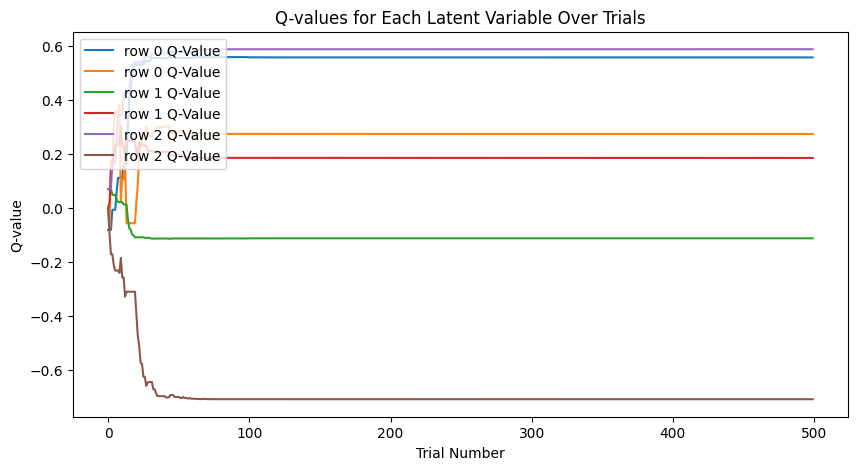

In [ ]:
import matplotlib.pyplot as plt
d = low_d
latent = len(d[0]['agent_info']['Q'])

rows = [[] for _ in range(latent)]

#Q-values for each latent variable
for trial_data in d:
    for i in range(latent):
        rows[i].append(trial_data['agent_info']['Q'][i])

fig, ax = plt.subplots(figsize=(10, 5))
for i, row in enumerate(rows):
    ax.plot(row, label=f'row {i} Q-Value')

ax.set_title('Q-values for Each Latent Variable Over Trials')
ax.set_ylabel('Q-value')
ax.set_xlabel('Trial Number')
ax.legend(loc='upper left')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_policy_over_time(data, ntrials_per_episode, nstates, nactions, rewarded_cues):
    #  policy data for each cue
    policy_data = {cue: [] for cue in range(nstates)}
    true_actions = {cue: 0 if cue in rewarded_cues else 1 for cue in range(nstates)}  # Example mapping

    # forward pass
    for entry in data:
        cue = entry['obs']
        q_values = entry['agent_info']['Q']
        one_hot_state = np.zeros(nstates)
        one_hot_state[cue] = 1
        latent_projection = np.dot(one_hot_state, entry['agent_info']['W'])
        projected_q_values = np.dot(latent_projection, q_values)
        policy_data[cue].append(np.argmax(projected_q_values))

    fig, axes = plt.subplots(nrows=nstates, ncols=1, figsize=(10, 2 * nstates), sharex=True)

    for cue in range(nstates):
        ax = axes[cue]
        #  trial numbers
        trial_numbers = list(range(len(policy_data[cue])))
        #  policy for the cue
        ax.plot(trial_numbers, policy_data[cue], label=f'Cue {cue} Policy')
        ax.axhline(y=true_actions[cue], color='r', linestyle='--', label=f'Cue {cue} True Action')
        ax.set_title(f'Policy for Cue {cue} Over Trials')
        ax.set_ylabel('Action')
        ax.legend(loc='upper left')

    plt.xlabel('Trial Number')
    plt.tight_layout()
    plt.show()


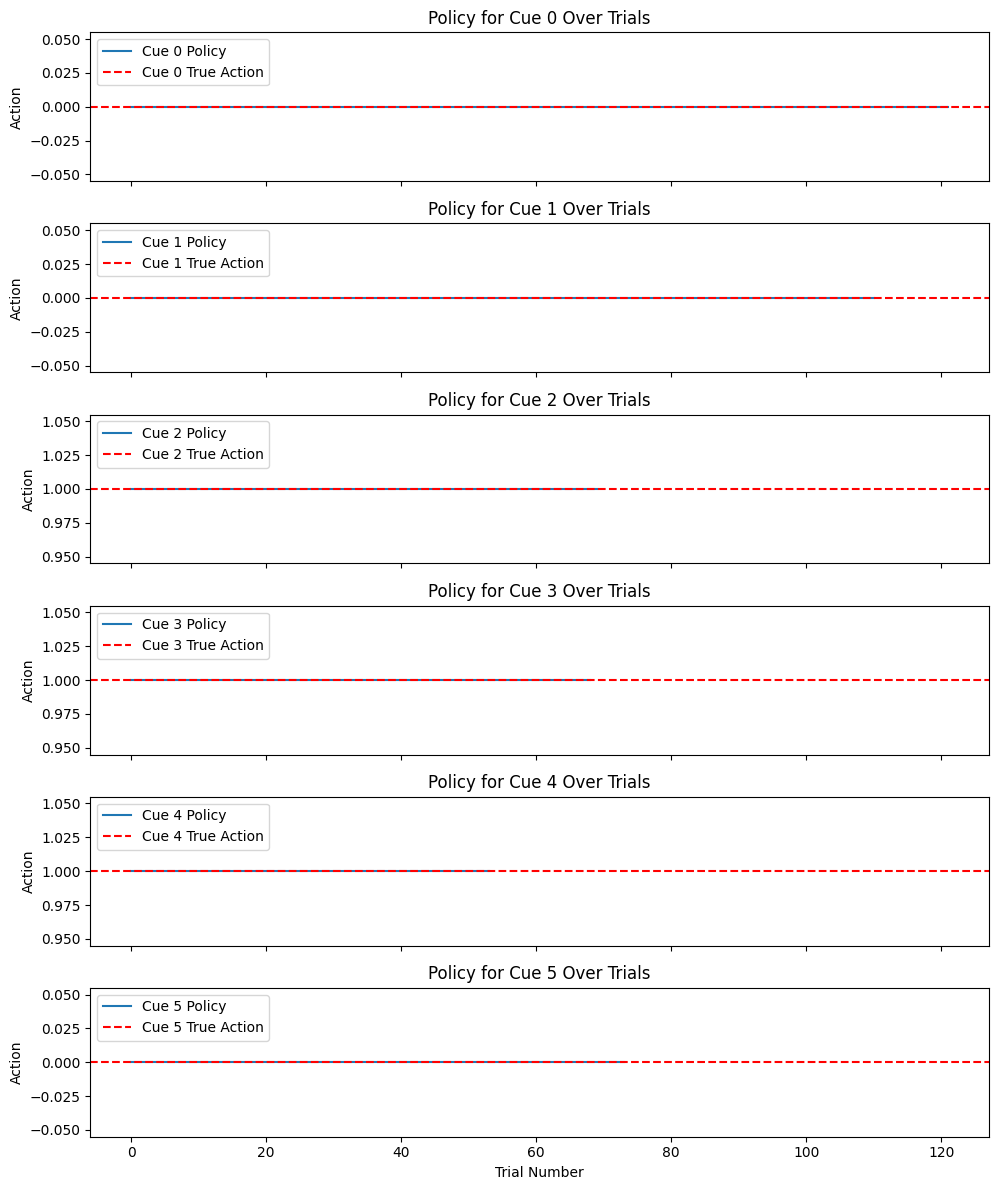

In [ ]:
plot_policy_over_time(high_d, ntrials_per_episode=500, nstates=6, nactions=2, rewarded_cues=high_r)

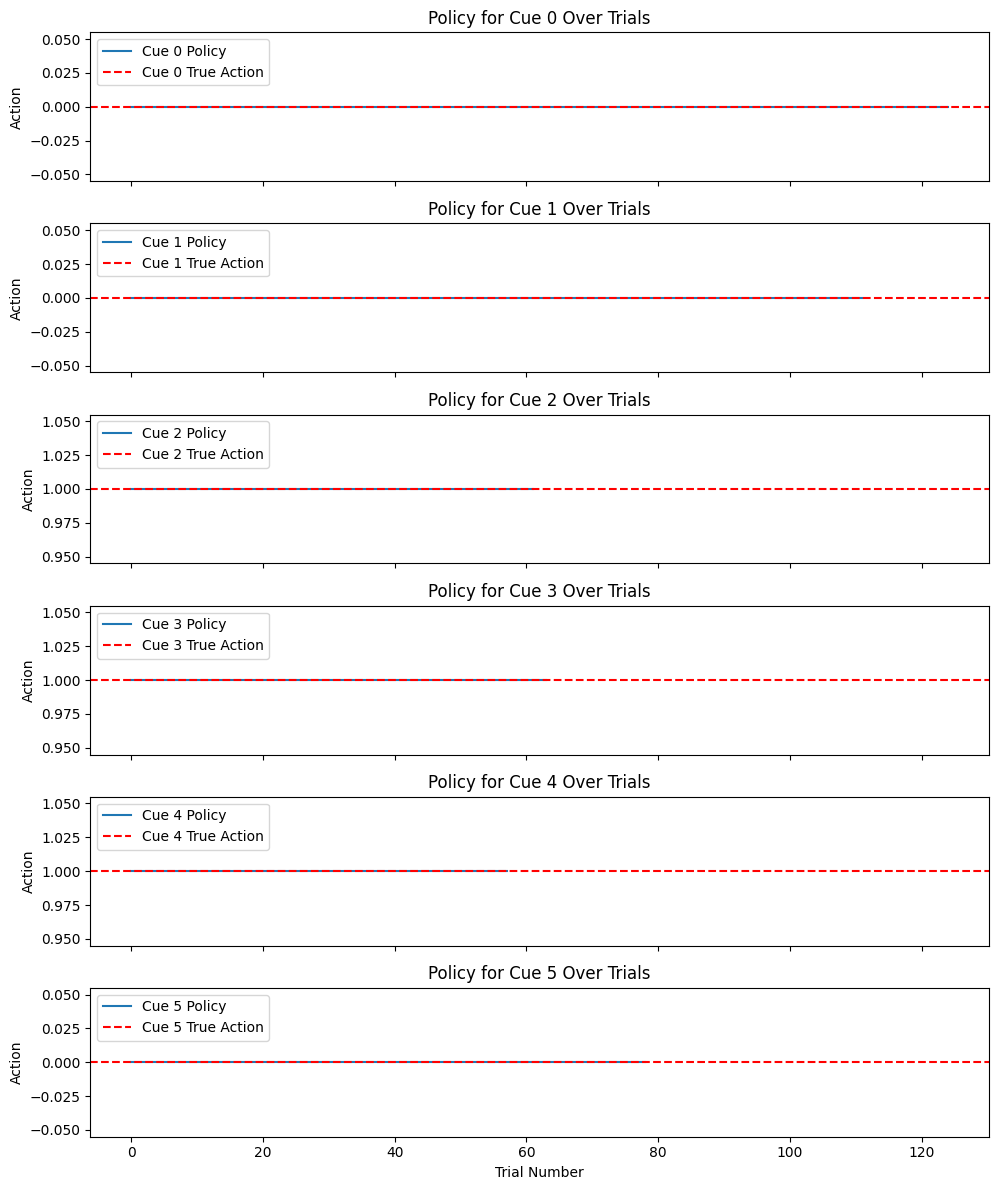

In [ ]:
plot_policy_over_time(low_d, ntrials_per_episode=500, nstates=6, nactions=2, rewarded_cues=low_r)

In [ ]:
def plot_rpe_variance(data_for_cues, ntrials_per_episode, plot_title, n_trials_to_plot=80):
    fig, axs = plt.subplots(1, len(data_for_cues), figsize=(12, 6))
    fig.suptitle(plot_title)

    for i, cue in enumerate(data_for_cues.keys()):
        rpe_data1, rpe_data2 = data_for_cues[cue]

        mean1 = np.mean(rpe_data1, axis=0)[:n_trials_to_plot]
        std1 = np.std(rpe_data1, axis=0)[:n_trials_to_plot] / np.sqrt(len(rpe_data1))

        mean2 = np.mean(rpe_data2, axis=0)[:n_trials_to_plot]
        std2 = np.std(rpe_data2, axis=0)[:n_trials_to_plot] / np.sqrt(len(rpe_data2))

        trial_numbers = list(range(n_trials_to_plot))

        axs[i].fill_between(trial_numbers, mean1 - std1, mean1 + std1, alpha=0.5)
        axs[i].plot(trial_numbers, mean1, label=f'Cue {cue} - {plot_title.split(" vs ")[0]}')
        axs[i].fill_between(trial_numbers, mean2 - std2, mean2 + std2, alpha=0.5)
        axs[i].plot(trial_numbers, mean2, label=f'Cue {cue} - {plot_title.split(" vs ")[1]}')

        axs[i].set_xlabel('Trial Number')
        axs[i].set_ylabel('Reward Prediction Error (RPE)')
        axs[i].legend()
        axs[i].set_title(f'Cue {cue}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f"{plot_title.replace(' ', '_').replace(':', '')}.png"
    plt.savefig("q012w003/" + filename)
    plt.show()

In [ ]:
import itertools
import matplotlib.pyplot as plt

# Define the presets
presets = ["OnlyWPlastic", "OnlyQPlastic", "QWPlastic", "OnlyWPlasticFreeze", "OnlyQPlasticFreeze", "QWPlasticFreeze"]

nruns = 100
ntrials_per_episode = 500
cues = [4, 5]

# Iterate over each combination of presets
for preset1, preset2 in itertools.combinations(presets, 2):
    print(f"Generating plot: {preset1} vs {preset2}")

    # Collect data for all cues
    data_for_cues = {}
    for cue in cues:
        data_for_cues[cue] = (
            collect_rpe_data(nruns, latent=6, cue=cue, ntrials_per_episode=ntrials_per_episode, preset=preset1),
            collect_rpe_data(nruns, latent=6, cue=cue, ntrials_per_episode=ntrials_per_episode, preset=preset2)
        )

    # Plotting
    plot_title = f"{preset1} vs {preset2}"
    plot_rpe_variance(data_for_cues, ntrials_per_episode, plot_title=plot_title)


In [ ]:
def plot_rpe_variance(data_for_cues, ntrials_per_episode, plot_title, n_trials_to_plot=80):
    fig, axs = plt.subplots(1, len(data_for_cues), figsize=(12, 6))
    fig.suptitle(plot_title)

    for i, (cue_pair) in enumerate(data_for_cues.keys()):
        old_cue, new_cue = cue_pair
        old_cue_data, new_cue_data = data_for_cues[cue_pair]

        mean_old = np.mean(old_cue_data, axis=0)[:n_trials_to_plot]
        std_old = np.std(old_cue_data, axis=0)[:n_trials_to_plot] / np.sqrt(len(old_cue_data))

        mean_new = np.mean(new_cue_data, axis=0)[:n_trials_to_plot]
        std_new = np.std(new_cue_data, axis=0)[:n_trials_to_plot] / np.sqrt(len(new_cue_data))

        trial_numbers = list(range(n_trials_to_plot))

        axs[i].fill_between(trial_numbers, mean_old - std_old, mean_old + std_old, alpha=0.5)
        axs[i].plot(trial_numbers, mean_old, label=f'Old Cue {old_cue}')
        axs[i].fill_between(trial_numbers, mean_new - std_new, mean_new + std_new, alpha=0.5)
        axs[i].plot(trial_numbers, mean_new, label=f'New Cue {new_cue}')

        axs[i].set_xlabel('Trial Number')
        axs[i].set_ylabel('Reward Prediction Error (RPE)')
        axs[i].legend()
        axs[i].set_title(f'Old Cue {old_cue} vs New Cue {new_cue}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f"{plot_title.replace(' ', '_').replace(':', '')}.png"
    plt.savefig("plots_00120003/" + filename)
    plt.show()


In [ ]:
old_cues = [1, 2]
new_cues = [4, 5]
presets = ["OnlyWPlastic", "OnlyQPlastic", "QWPlastic", "OnlyWPlasticFreeze", "OnlyQPlasticFreeze", "QWPlasticFreeze"]

nruns = 100
ntrials_per_episode = 500
for preset in presets:
    print(f"Generating plot for preset: {preset}")

    data_for_cues = {}
    for old_cue, new_cue in zip(old_cues, new_cues):
        old_cue_data = collect_rpe_data(nruns, latent=6, cue=old_cue, ntrials_per_episode=ntrials_per_episode, preset=preset)
        new_cue_data = collect_rpe_data(nruns, latent=6, cue=new_cue, ntrials_per_episode=ntrials_per_episode, preset=preset)
        data_for_cues[(old_cue, new_cue)] = (old_cue_data, new_cue_data)  # Store both cue numbers and their data

    plot_title = f"Preset: {preset}"
    plot_rpe_variance(data_for_cues, ntrials_per_episode, plot_title=plot_title)